# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Actividad Semanas 6 y 7

### **Modelado de tópicos - LSI/LDA**

#### **Nombres y matrículas de los integrantes del equipo:**


*   Nathalia Prada - A01793999
*   Jessica Paola Pulido  - A01793650
*   Isaid Posadas Oropeza - A01795015
*   Sergio Pulido Morales - A01794935
*   Carlos Mariano Ramírez Amaya - A01795036


El archivo noticiasTopicModeling.txt consiste en
5658 noticias de varios periódicos de España. El archivo de texto es una lista en el siguiente
formato:
 [{“titular”:”Encabezado“, “texto”:”Cuerpo”}, … , {“titular”:”Encabezado”,”texto”:”Cuerpo”}]
Donde “titular” es el encabezado de la noticia y “texto” es el cuerpo del texto de dicha noticia. En
particular en esta actividad trabajarás solamente con los cuerpos de las noticias, sin incluir los
encabezados. Carga dicho archivo y genera un DataFrame de Pandas llamado “df” y que contiene
una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.


In [32]:
#Librerías y recursos utilizados
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json
import spacy
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import gensim
import gensim.corpora as corpora
from gensim.models.ldamulticore import LdaMulticore
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


!python -m spacy download es_core_news_sm

# Descargar el recurso necesario para la lematización
nltk.download('omw')  # Descarga WordNet en español

nltk.download('stopwords')

nltk.download('punkt')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 25.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
from google.colab import drive
drive.mount('/content/drive')

import os
DIR = "/content/drive/My Drive/TEC/PLN/Semana6"
os.chdir(DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Leer el archivo JSON
with open("noticiasTopicModeling.txt", "r", encoding="utf-8") as file:
    noticias = json.load(file)

# Extraer el texto de las noticias
cuerpos_noticias = [noticia["texto"] for noticia in noticias]

# Crear el DataFrame de Pandas
df = pd.DataFrame(cuerpos_noticias, columns=["noticia"])

df.head()

noticia
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [35]:
# Confirmar el número de renglones
num_renglones = len(df)

print(f"El DataFrame tiene {num_renglones} renglones.")

El DataFrame tiene 5658 renglones.


Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en
español. Recuerda que el objetivo es identificar los tokens (palabras) que describan mejor la
distribución de cada tema.
NOTA: Recuerda que esta es una técnica no supervisada, por lo que no requerimos hacer una
partición de los datos.

In [36]:
# Cargar el modelo lingüístico en español
nlp = spacy.load('es_core_news_sm')

# Definir stopwords en español y agregar stopwords adicionales específicas del contexto
spanish_stopwords = set(stopwords.words('spanish'))
additional_stopwords = [
    'si', 'the', 'erte',
    'primera', 'segunda', 'mismo',
    'hacer', 'puede', 'través', 'además', 'actual', 'ahora', 'siguiente', 'según', 'aunque',
    'así', 'porque', 'cuando', 'donde', 'quien', 'cual', 'pero', 'sin', 'sobre', 'entre',
    'hasta', 'desde', 'tras', 'contra', 'ante', 'con', 'del', 'por', 'para', 'como', 'y', 'o', 'u',
    'ni', 'e', 'a', 'de', 'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'lo', 'al'
]
spanish_stopwords.update(additional_stopwords)

# Normalización
def normalize(text):
    return text.lower()

# Eliminar caracteres especiales y puntuación
def remove_special_characters(text):
    return re.sub(r'[^a-zA-ZáéíóúüÁÉÍÓÚÜñÑ\s]', ' ', text)

# Eliminar espacios en blanco extra
def remove_extra_whitespaces(text):
    return re.sub(r'\s+', ' ', text).strip()

# Simplificar caracteres repetidos en cada token
def simplify_repeated_characters(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

# Tokenización
def tokenize(text):
    return word_tokenize(text, language='spanish')

# Eliminar stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in spanish_stopwords]

# Filtrar tokens por longitud (mayor a 1)
def filter_short_tokens(tokens):
    return [token for token in tokens if len(token) > 1]

# Lematización
def lemmatize(tokens):
    text = ' '.join(tokens)
    doc = nlp(text)
    relevant_pos = ['VERB', 'NOUN', 'ADJ', 'ADV', 'PROPN']
    lemmas = [token.lemma_ for token in doc if token.pos_ in relevant_pos and not token.is_stop and token.lemma_ != '-PRON-']
    lemmas_prashal = ' '.join(lemmas)
    text = remove_extra_whitespaces(lemmas_prashal)
    text = simplify_repeated_characters(text)
    tokens = tokenize(text)
    lemmas = remove_stopwords(tokens)

    return lemmas

# Aplicar todas las funciones de preprocesamiento, incluida la lematización y filtrado de palabras cortas
def preprocess(text):
    text = normalize(text)
    text = remove_special_characters(text)
    text = remove_extra_whitespaces(text)
    text = simplify_repeated_characters(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = filter_short_tokens(tokens)
    lemmas = lemmatize(tokens)
    # Filtrar lemas que tienen menos de 1 letra
    lemmas = [lemma for lemma in lemmas if len(lemma) > 1]
    return lemmas


# Aplicar el preprocesamiento a cada noticia en el DataFrame
df['noticia_cleaned'] = df['noticia'].apply(preprocess)

In [37]:
# Confirmar el número de renglones
num_renglones = len(df)
print(f"El DataFrame tiene {num_renglones} renglones.")

El DataFrame tiene 5658 renglones.


In [38]:
# Mostrar las primeras filas del DataFrame con los datos limpios
df['noticia_cleaned'].head()

0                                                                         [españa, dejado, católico, decir, manuel, azaña, comienzo, repúblicar, congreso, diputados, aprobar, ley, laicista, metáforo, católico, papel, ley, creencia, pueblo, migración, integración, europeo, programa, europa, españa, domingo, noviembre, dejado, excepción, europa, potencia, extremo, derecho, parlamento, metáforo, precisamente, excepcional, dictadura, mediados, setento, dictador, mausoleo, año, muerto, existir, cosa, portugal, grecia, italia, alemania, país, dictadura, fascista, españa, pasar, portugal, italia, alemania, derrotar, fascismo, franquismo, morir, cama, harakiri, corte, franquista, ruptura, régimen, reforma, nacer, país, país, mutar, ley, ley, españa, parecer, vacunado, año, franquismo, llegar, irrupción, posfranquismo, actor, fundamental, gobierno, autonómico, local, pp, ciudadanos, españa, dejado, excepción, alianzo, popular, manuel, fraga, bebiero, franquismo, sociológico, ...]
1             

Longitud del diccionario: 78838

Palabras más comúnes (Palabra,Frecuencia):
[('año', 11349), ('gobierno', 10920), ('caso', 10252), ('persona', 8331), ('público', 6591), ('político', 6521), ('madrid', 6156), ('españa', 6028), ('etiqueta', 5709), ('país', 5631)]


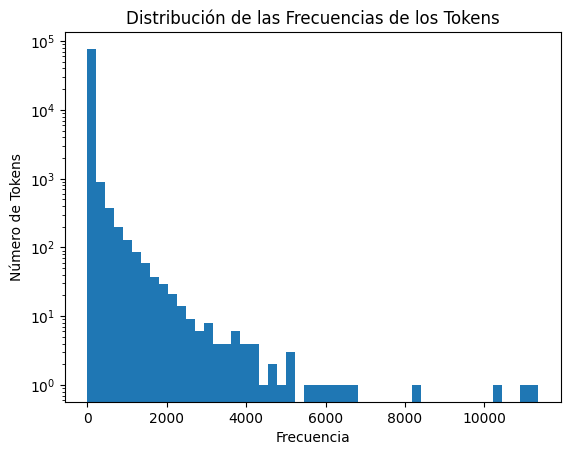

Estadísticas descriptivas de las frecuencias:
Media: 27.446041249143814
Mediana: 2.0
Mínimo: 1
Máximo: 11349
Desviación estándar: 175.00754666783155


In [39]:
# Crear un diccionario de frecuencia de palabras
clean_doc=df[['noticia_cleaned']]

midiccionario = Counter()

for k in range(len(clean_doc)):
    midiccionario.update(clean_doc.iloc[k, 0])

# Mostrar la longitud del diccionario y las palabras más comunes
print('Longitud del diccionario:', len(midiccionario))
print('\nPalabras más comúnes (Palabra,Frecuencia):')
print(midiccionario.most_common(10))

# Análisis Exploratorio de Frecuencias
frecuencias = list(midiccionario.values())
plt.hist(frecuencias, bins=50, log=True)
plt.title('Distribución de las Frecuencias de los Tokens')
plt.xlabel('Frecuencia')
plt.ylabel('Número de Tokens')
plt.show()

print('Estadísticas descriptivas de las frecuencias:')
print(f'Media: {np.mean(frecuencias)}')
print(f'Mediana: {np.median(frecuencias)}')
print(f'Mínimo: {np.min(frecuencias)}')
print(f'Máximo: {np.max(frecuencias)}')
print(f'Desviación estándar: {np.std(frecuencias)}')

In [40]:
min_freq = 2
"""Se utiliza este valor puesto que se elimina una cantidad considerable de
palabras con baja frecuencia """

midicc = {token: freq for token, freq in midiccionario.items() if freq >= min_freq}

original_length = len(midiccionario)
new_length = len(midicc)
percentage_removed = ((original_length - new_length) / original_length) * 100

print(f'Porcentaje de elementos eliminados: {percentage_removed:.2f}%')

print('Nueva longitud del nuevo vocabulario:', len(midicc))
print(list(midicc.items())[0:10])     # veamos algunos elementos del diccionario.

mivocab = list(midicc.keys())     # Obtenemos nuestro vocabulario de tokens/palabras.

Porcentaje de elementos eliminados: 42.13%
Nueva longitud del nuevo vocabulario: 45620
[('españa', 6028), ('dejado', 688), ('católico', 147), ('decir', 1600), ('manuel', 889), ('azaña', 11), ('comienzo', 278), ('repúblicar', 22), ('congreso', 1603), ('diputados', 86)]


In [41]:
# Convertir 'midicc' a un conjunto para mejorar la eficiencia en la búsqueda
midicc_set = set(midicc)

# Filtrar las palabras de cada noticia y unirlas en una cadena
clean_doc_filtered = [' '.join(filter(midicc_set.__contains__, news)) for news in df['noticia_cleaned']]

In [42]:
clean_doc_filtered[0:5]

['españa dejado católico decir manuel azaña comienzo repúblicar congreso diputados aprobar ley laicista metáforo católico papel ley creencia pueblo migración integración europeo programa europa españa domingo noviembre dejado excepción europa potencia extremo derecho parlamento metáforo precisamente excepcional dictadura mediados setento dictador mausoleo año muerto existir cosa portugal grecia italia alemania país dictadura fascista españa pasar portugal italia alemania derrotar fascismo franquismo morir cama harakiri corte franquista ruptura régimen reforma nacer país país mutar ley ley españa parecer vacunado año franquismo llegar irrupción actor fundamental gobierno autonómico local pp ciudadanos españa dejado excepción alianzo popular manuel fraga franquismo sociológico fuerzo bla piñar búnker franquista franquismo sociológico mantener pp tiempo escisión pp españa reinstauración democrática existido fuerza extremo derecho voto escaño fenómeno pasar país europeo operar españa polar

# Parte 1: Indexación semántica latente (LSI):

3. Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con
algunas de sus columnas con sus nombres, donde las columnas son los tokens. ¿Cuál es el
significado de cada renglón? ¿Y el significado de cada columna?

In [43]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Mostrar todo el contenido de las celdas
pd.set_option('display.max_colwidth', None)
"""Asegurarse de que los documentos están en forma de cadenas de texto
ya que  TfidfVectorizer está diseñado para manejar texto sin procesar,
aplicando técnicas de preprocesamiento como tokenización, eliminación de stopwords,
y transformación a minúsculas.Si clean_doc_filtered ya está en forma de cadenas,
 no es necesario convertir"""

if isinstance(clean_doc_filtered[0], list):
    clean_doc_filtered_str = [' '.join(doc) for doc in clean_doc_filtered]
else:
    clean_doc_filtered_str = clean_doc_filtered

# Inicializar el objeto TfidfVectorizer con el vocabulario mivocab
tfidf_vectorizer = TfidfVectorizer(vocabulary=mivocab)

# Ajustar y transformar los documentos en matrices dispersas TF-IDF
tfidf = tfidf_vectorizer.fit_transform(clean_doc_filtered_str)

# Convertir la matriz TF-IDF a un DataFrame de pandas
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Mostrar los primeros 5 renglones y algunas de sus columnas

tfidf_df.iloc[:5, :10]  # Mostrar las primeras 10 columnas como ejemplo

,españa,dejado,católico,decir,manuel,azaña,comienzo,repúblicar,congreso,diputados
0,0.147155,0.104827,0.108974,0.030145,0.071254,0.081488,0.044438,0.071088,0.032744,0.056408
1,0.010783,0.000000,0.027949,0.015463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.015251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.014249,0.016840,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



**TF-IDF (Term Frequency-Inverse Document Frequency):** Es una técnica de ponderación que refleja la importancia de una palabra en un documento en el contexto de una colección o corpus de documentos. Se calcula como el producto de dos métricas:
TF (Term Frequency): Frecuencia de una palabra en un documento.
IDF (Inverse Document Frequency): Medida de cuánto informa una palabra, es decir, si es común o rara en todo el corpus de documentos.

### ¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?

La matriz resultante es una representación numérica de los documentos, donde cada fila corresponde a un documento y cada columna a una palabra del vocabulario. Los valores en la matriz son las puntuaciones TF-IDF de las palabras en los documentos.

- Filas: Cada fila del DataFrame representa un documento de la lista clean_doc_filtered.

- Columnas: Cada columna representa una palabra del vocabulario mivocab.

- Valores: Los valores en la tabla son las puntuaciones TF-IDF de cada palabra en cada documento.

4. Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con
10 componentes y obtener el gráfico de la importancia relativa de estas.

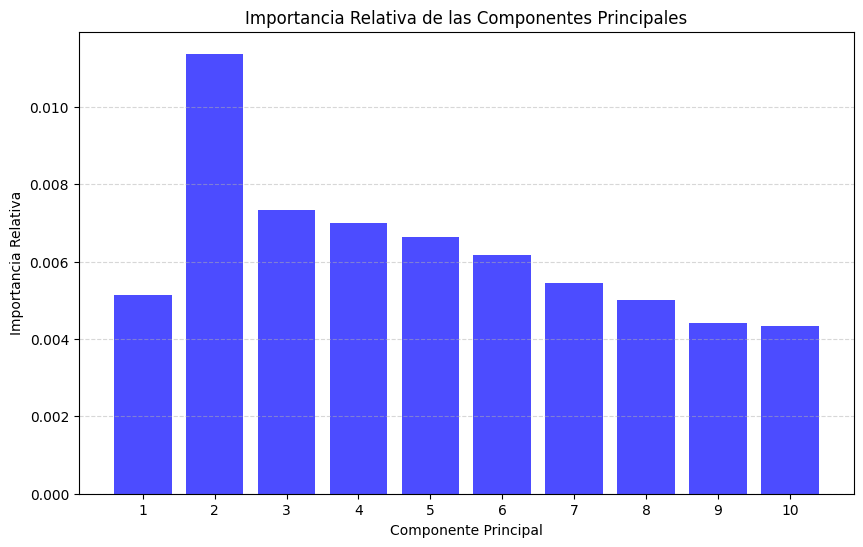

In [44]:
# Aplicar TruncatedSVD con 10 componentes
'''Creamos un objeto TruncatedSVD con 10 componentes principales.
Esto significa que queremos reducir la dimensionalidad de los datos
a 10 dimensiones principales.'''
svd = TruncatedSVD(n_components=10)

'''
Aplicamos TruncatedSVD a la matriz TF-IDF. Esto nos da una
versión transformada de la matriz TF-IDF con una dimensionalidad reducida
a 10 componentes principales.
'''
tfidf_svd = svd.fit_transform(tfidf)

# Obtener la importancia relativa de las componentes
'''explained_variance_ratio_ nos da la proporción de la varianza total
explicada por cada una de las componentes principales seleccionadas.
Esto nos ayuda a entender cuánta información de los datos originales
se conserva en cada componente.'''

importancia_rel = svd.explained_variance_ratio_

# Graficar la importancia relativa de las componentes
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(importancia_rel) + 1), importancia_rel, color='blue', alpha=0.7)
plt.title('Importancia Relativa de las Componentes Principales')
plt.xlabel('Componente Principal')
plt.ylabel('Importancia Relativa')
plt.xticks(range(1, len(importancia_rel) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Gráfico de barras donde el eje x representa cada componente principal y el eje y representa la importancia relativa de esa componente. Este gráfico nos da una idea de cuánta varianza está explicada por cada componente y nos ayuda a entender mejor la estructura de nuestros datos después de la reducción de dimensionalidad.

5. Obtener la matriz tokens-temas (term-topic) a partir de la matriz 𝑉
்
 de la descomposición SVD.
Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.


In [45]:
# Obtener la matriz de carga derecha de la descomposición SVD
matriz_carga_derecha = svd.components_

# Crear un DataFrame para la matriz de carga derecha
tokens_temas_df = pd.DataFrame(matriz_carga_derecha, columns=tfidf_vectorizer.get_feature_names_out())

# Desplegar los primeros 5 renglones de la matriz de tokens-temas
tokens_temas_df.head(5)

,españa,dejado,católico,decir,manuel,azaña,comienzo,repúblicar,congreso,diputados,...,calypso,sedaris,perd,amal,gladstone,waldo,yagá,dubravka,ugre,mainl
0,0.091187,0.018409,0.003784,0.027031,0.019586,0.000357,0.009120,0.000792,0.039433,0.003734,...,0.000058,0.000087,0.000058,0.000058,0.000058,0.000087,0.000116,0.000058,0.000058,0.000116
1,0.013826,0.001580,-0.003454,-0.019117,-0.030642,-0.000414,0.008205,-0.001263,-0.076098,-0.007592,...,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000003,-0.000002,-0.000002,-0.000003
2,-0.031782,0.001730,-0.005649,-0.023542,0.003276,-0.000696,-0.002564,-0.000949,0.057061,0.006043,...,-0.000229,-0.000343,-0.000229,-0.000229,-0.000229,-0.000343,-0.000457,-0.000229,-0.000229,-0.000457
3,-0.049297,-0.010241,-0.000022,-0.003506,-0.006737,0.000627,0.002310,0.000318,-0.034724,-0.003916,...,0.000029,0.000043,0.000029,0.000029,0.000029,0.000043,0.000058,0.000029,0.000029,0.000058
4,-0.009172,-0.006725,0.000615,-0.003814,0.045473,-0.000076,-0.002168,0.000278,-0.012039,-0.000707,...,0.000041,0.000061,0.000041,0.000041,0.000041,0.000061,0.000082,0.000041,0.000041,0.000082


6. Con base a la cantidad de conceptos latentes que determinaste en el ejercicio anterior, obtener cada
uno de sus gráficos con sus 10 términos/tokens más importantes.

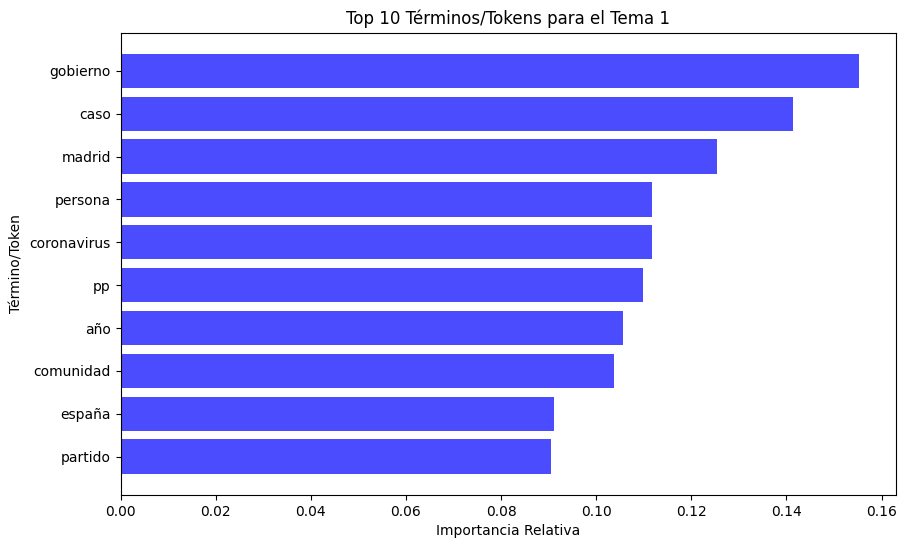

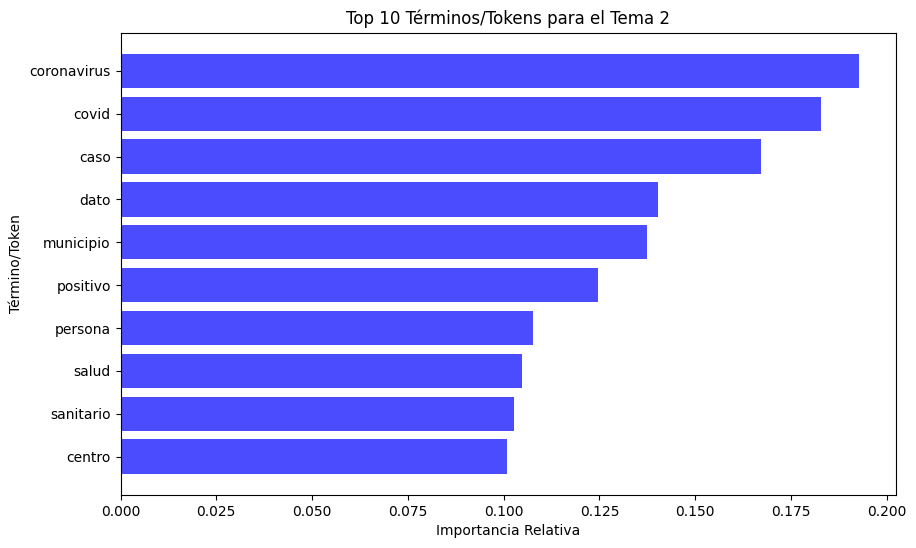

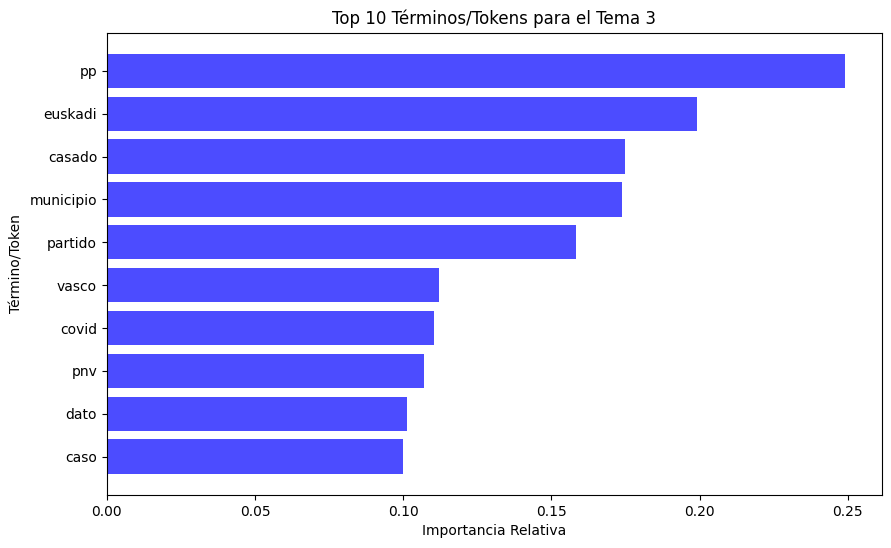

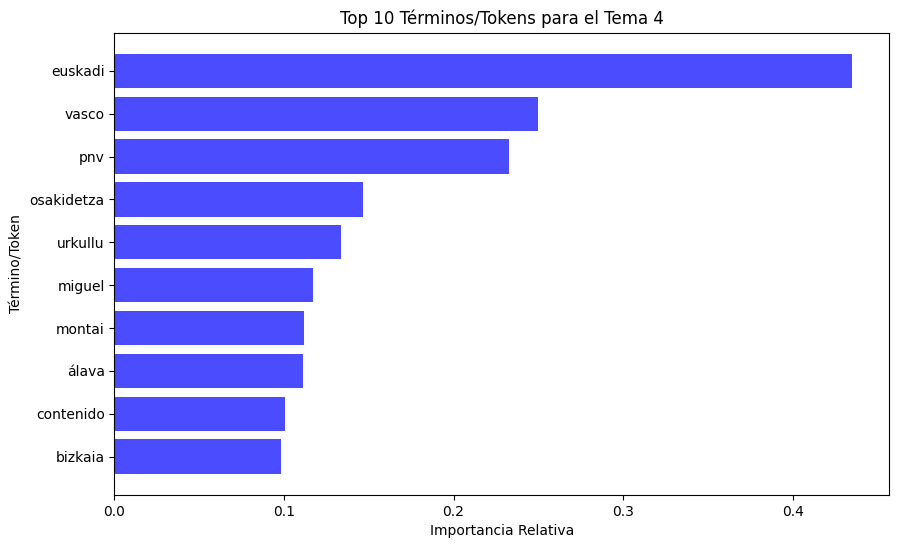

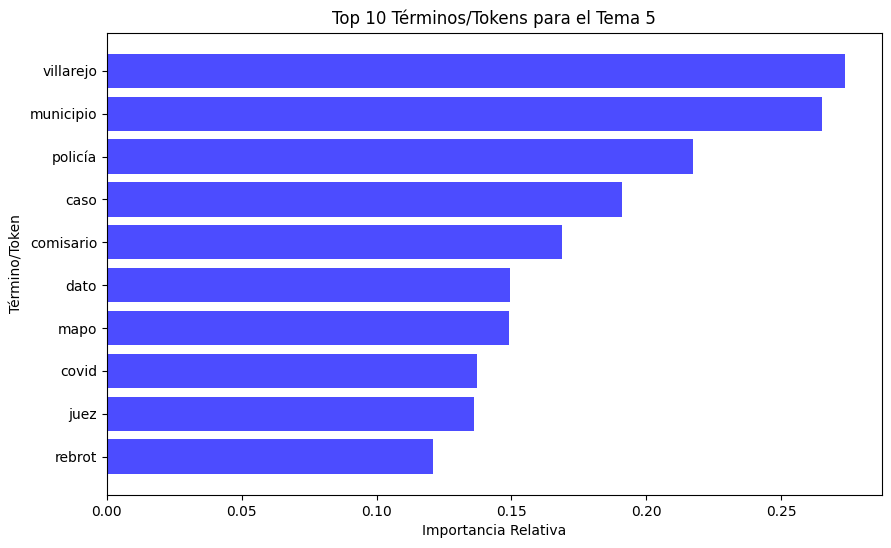

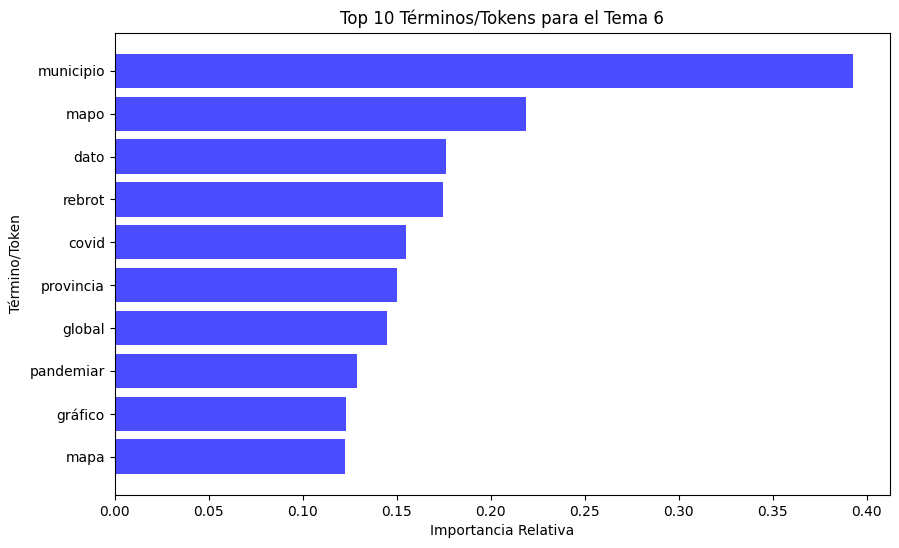

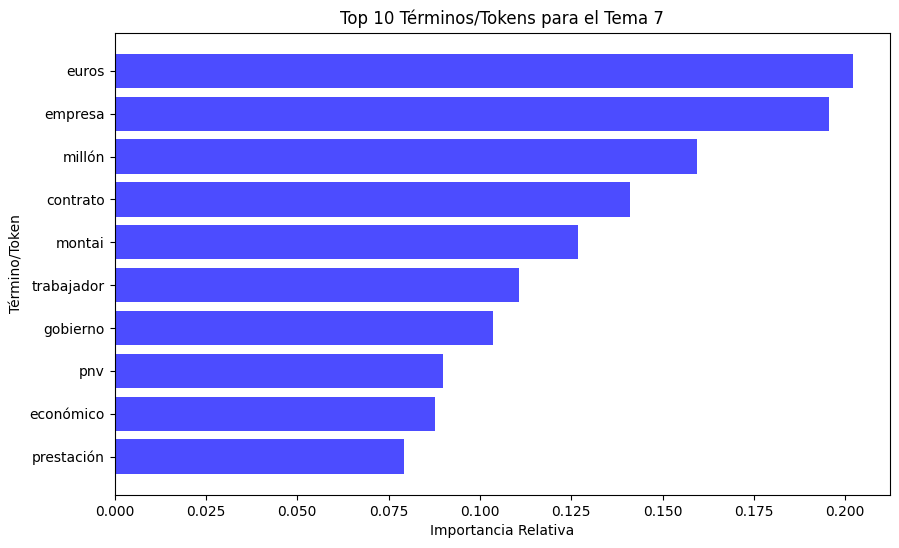

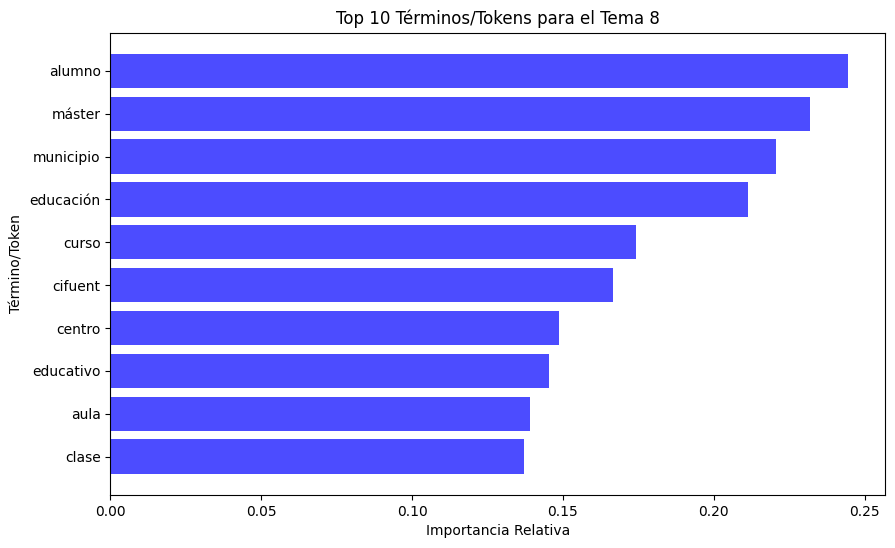

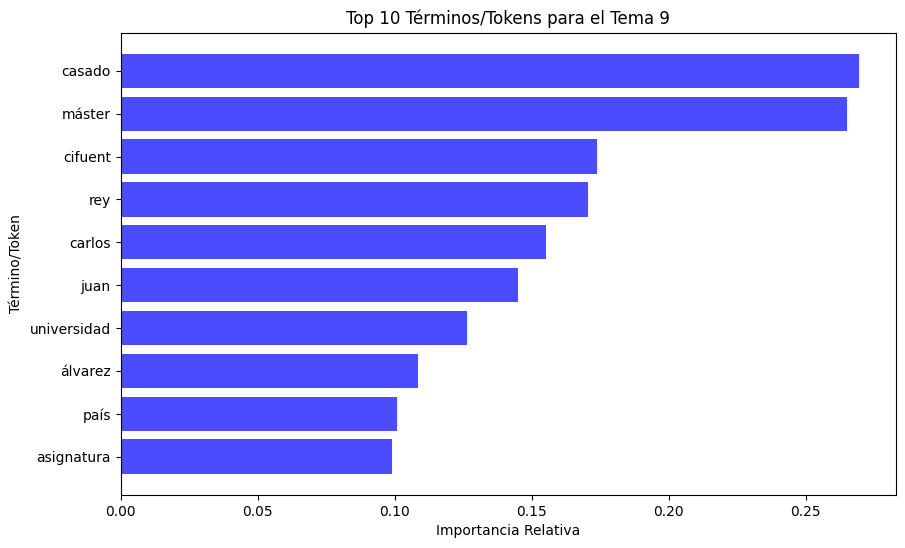

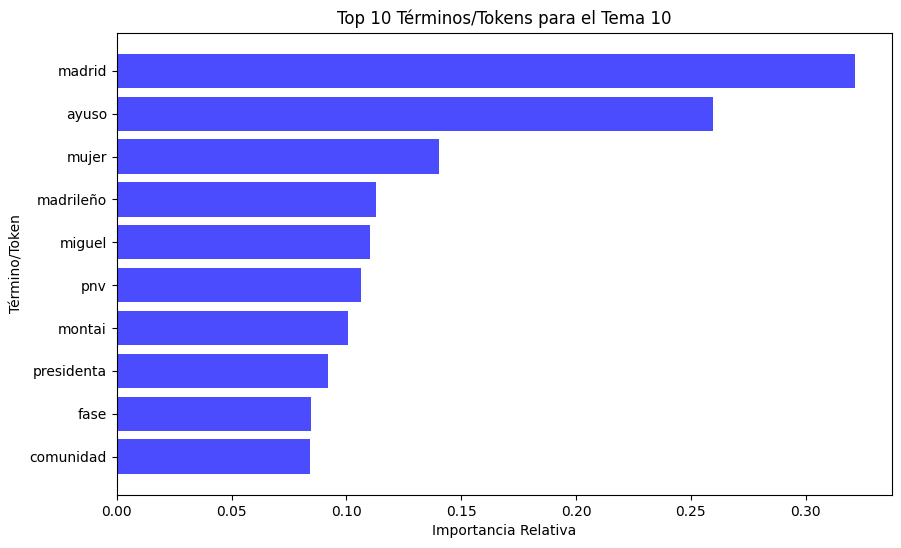

In [46]:
# Número de conceptos latentes (temas)
num_temas = 10
"""Con base en la importancia relativa de las componentes
principales se determinó este número, sin embargo la importancia relativa al ser
de valores muy pequeños significa que cada componente principal captura sólo una
pequeña fracción de la varianza total. Esto puede ser un indicador de que la
variabilidad en los datos está distribuida entre muchos componentes pequeños """
# Obtener los 10 términos/tokens más importantes para cada tema
for i in range(num_temas):
    # Obtener los índices de los 10 términos/tokens más importantes para el tema i
    indices_top_10 = tokens_temas_df.iloc[i].argsort()[-10:][::-1]
    # Obtener los nombres de los términos/tokens correspondientes a esos índices
    top_10_tokens = tokens_temas_df.columns[indices_top_10]

    # Graficar los términos/tokens más importantes para el tema i
    plt.figure(figsize=(10, 6))
    plt.barh(range(10), tokens_temas_df.iloc[i, indices_top_10], color='blue', alpha=0.7)
    plt.yticks(range(10), top_10_tokens)
    plt.title('Top 10 Términos/Tokens para el Tema {}'.format(i+1))
    plt.xlabel('Importancia Relativa')
    plt.ylabel('Término/Token')
    plt.gca().invert_yaxis()  # Invertir el eje y para que los términos más importantes estén arriba
    plt.show()

* Cada concepto latente clasifica los términos considerados globalmente más relevantes que se encuentran dentro de cada noticia, el objetivo es definir temáticas en las que las noticias puedan clasificarse.

* Si bien estos términos pueden describir globalmente de que puede tratar cada noticia no da una gran profundidad de una idea general que resuma la noticia, además hay varios conceptos latentes similares.

# Parte 2: Asignación de Dirichlet Latente (LDA):

7. Utiliza la librería Gensim para implementar ahora la técnica de LDA.

In [47]:
# Se generá el corpus tokenizado ya filtrado con nuestro vocabulario
docs = list(map(lambda x: x.split(' '), clean_doc_filtered))
#se utiliza corpora para crear el diccionario necesario para Gensim
id2word = corpora.Dictionary(docs)
#se realiza la indexación con las tuplas (índice, frecuencia):
corpus = [id2word.doc2bow(doc) for doc in docs]

In [48]:
lda_model = LdaMulticore(corpus=corpus,
                    id2word=id2word,
                    num_topics=7,
                    chunksize=5,
                    passes=10,
                    alpha=0.2,
                    eta=0.2,
                    )

8. Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada? Compara tus resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias? ¿Cuál consideras puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a
considerar?

In [49]:
# Mostrar los tópicos generados por el modelo LDA
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico {idx+1}: {topic}")

Tópico 1: 0.023*"gobierno" + 0.012*"político" + 0.009*"partido" + 0.007*"sánchez" + 0.007*"ciudadano" + 0.006*"presidente" + 0.006*"psoe" + 0.005*"comisión" + 0.005*"líder" + 0.005*"derecho"
Tópico 2: 0.015*"caso" + 0.011*"policía" + 0.009*"investigación" + 0.008*"sexual" + 0.007*"juan" + 0.006*"delito" + 0.006*"miguel" + 0.006*"vasco" + 0.006*"civil" + 0.006*"euskadi"
Tópico 3: 0.009*"medida" + 0.009*"persona" + 0.008*"público" + 0.007*"social" + 0.007*"trabajo" + 0.007*"centro" + 0.006*"situación" + 0.006*"información" + 0.006*"crisis" + 0.005*"servicio"
Tópico 4: 0.031*"madrid" + 0.020*"pp" + 0.015*"casado" + 0.009*"partido" + 0.009*"lópez" + 0.009*"ayuso" + 0.009*"madrileño" + 0.008*"pablo" + 0.007*"presidenta" + 0.007*"ignacio"
Tópico 5: 0.033*"caso" + 0.016*"covid" + 0.015*"positivo" + 0.014*"salud" + 0.013*"sanidad" + 0.013*"persona" + 0.013*"comunidad" + 0.012*"coronavirus" + 0.011*"hospital" + 0.011*"dato"
Tópico 6: 0.020*"millón" + 0.014*"año" + 0.011*"país" + 0.010*"euros" +

* Realizando múltiples pruebas se considera que 7 es el número de tópicos más claro en la clasificación de temáticas.
* Al comparar con el método LSI se observa que hay gran similitud en los tópico / conceptos latentes. Se puede encontrar temáticas como "coronavirus y casos en Madrid", "contratos económicos del gobierno", "temas gubernamentales de Madrid". Hay una temática que se encuentra usando tanto LSI como LDA y es temas de Euskadi, sin embargo, no se refieren a algo en específico, y se podría asumir que engloba todas las noticias que tengan palabras en euskera o hablen de la comunidad per sé. Se debería considerar o segmentar las noticias que sólo estén en castellano.

 9. Conclusiones:

## Conclusiones sobre LSI y LDA

### Conclusiones sobre LSI (Latent Semantic Indexing)

1. **Simplicidad y Velocidad**: LSI es fácil de implementar y se ejecuta rápidamente, lo cual es ventajoso cuando se necesita una solución rápida y eficiente para manejar grandes conjuntos de datos.
2. **Captura de Relaciones Semánticas**: LSI es eficaz para identificar relaciones latentes entre palabras en el texto, lo que puede revelar conceptos implícitos que no son evidentes a primera vista.
3. **Limitaciones en la Interpretación de Temas**: Aunque LSI puede identificar relaciones semánticas, los temas resultantes a menudo son menos coherentes y más difíciles de interpretar en comparación con LDA. Los conceptos latentes identificados por LSI pueden ser más ambiguos y no reflejar claramente temas específicos.

### Conclusiones sobre LDA (Latent Dirichlet Allocation)

1. **Interpretabilidad de Temas**: LDA está diseñado específicamente para identificar y describir temas en un corpus de documentos. Los temas generados por LDA son más coherentes y claramente definidos, lo que facilita su interpretación.
2. **Coherencia de Temas**: Los temas identificados por LDA tienden a ser más coherentes y fácilmente comprensibles, lo que permite una mejor comprensión de la estructura temática del corpus.
3. **Modelo Probabilístico**: LDA utiliza un modelo probabilístico que permite inferir la distribución de palabras en temas y la distribución de temas en documentos, proporcionando una representación más robusta de la estructura temática.
4. **Complejidad y Tiempo de Computación**: LDA es más complejo y puede ser más lento de entrenar en comparación con LSI, especialmente con grandes conjuntos de datos. Sin embargo, los resultados suelen justificar el esfuerzo adicional debido a la mayor claridad y coherencia de los temas identificados.


*   Al igual que en las anteriores actividad la limpieza y tratamiento de los datos es fundamental para poder encontrar un modelo que arroje resultados óptimos.
*   Los modelos LSI y LDA generaron clasificación de tópicos muy cercanas, por lo que ambas podrían considerarse bastante útiles para el modelado de temas, podría considerarse en esta actividad que el uso de gemsim para LDA facilitó el proceso, sin embargo, esta misma librería también tiene modelado por LSI.
* Tanto para LSI como para LDA no deja de desvincular al analista en tomar decisiones para considerar ciertos parámetros que puedan mejorar el modelo.